# Alpha Factors



## 1.1 Set up - importing everything and setting it all up for SPX500

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
idx = pd.IndexSlice

# Define start and end dates
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)

# Fetch using yfinance
import yfinance as yf

# Fetch the list of S&P 500 companies along with their market capitalization
sp500_info = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_info = sp500_info.rename(columns={'Symbol': 'Ticker'})

# Fetch market capitalization using yfinance
market_caps = {}
for ticker in sp500_info['Ticker']:
    try:
        stock_info = yf.Ticker(ticker)
        market_cap = stock_info.info['marketCap']
        market_caps[ticker] = market_cap
    except:
        print(f"Error fetching market cap for {ticker}")

# Convert market caps to DataFrame
market_caps_df = pd.DataFrame.from_dict(market_caps, orient='index', columns=['MarketCap'])
market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False)

# Select the top 100 companies by market capitalization
top_symbols = market_caps_df.head(100).index

# Create a DataFrame to store monthly returns for the top 100 companies
top_returns = pd.DataFrame()

# Fetch and calculate returns for the top 100 S&P 500 companies
for stock_symbol in top_symbols:
    try:
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        stock_prices = stock_data['Adj Close']
        monthly_returns = stock_prices.resample('M').ffill().pct_change().dropna() #code to resample to monthly returns
        top_returns[stock_symbol] = monthly_returns
    except:
        print(f"Error fetching data for {stock_symbol}")

# Print the returns for the top 100 companies
print(top_returns)


Error fetching market cap for BRK.B
Error fetching market cap for BF.B
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

In [3]:
top_returns.describe()

,AAPL,MSFT,GOOG,GOOGL,AMZN,NVDA,META,TSLA,LLY,V,...,ETN,CVS,ZTS,SLB,CI,AMT,CB,C,BDX,PGR
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.006266,0.005877,0.003207,0.003047,0.002191,0.052137,0.011701,0.006366,0.048092,0.006498,...,0.022365,-0.021053,-0.001698,0.030947,0.014156,-0.013382,0.004088,-0.015876,0.008526,0.011323
std,0.090816,0.071194,0.093557,0.093824,0.126930,0.189587,0.171505,0.212126,0.083390,0.068641,...,0.076831,0.055722,0.064790,0.143257,0.068374,0.072944,0.062943,0.096191,0.058779,0.055880
min,-0.122272,-0.109267,-0.176750,-0.179467,-0.237525,-0.320274,-0.326342,-0.367334,-0.092759,-0.105984,...,-0.090981,-0.111862,-0.142536,-0.221932,-0.121451,-0.154891,-0.078190,-0.146282,-0.114250,-0.062243
25%,-0.065503,-0.046266,-0.052567,-0.055910,-0.089875,-0.070283,-0.086965,-0.135683,0.001360,-0.042811,...,-0.032436,-0.049921,-0.042448,-0.055154,-0.020243,-0.064135,-0.037610,-0.085588,-0.024606,-0.035972
50%,0.012785,-0.003306,-0.005951,-0.002976,0.011296,0.104652,0.024073,-0.070768,0.034425,0.001053,...,-0.011026,-0.026852,-0.003353,0.007478,0.012464,-0.018717,0.008460,-0.058424,0.023672,-0.003205
75%,0.075902,0.051382,0.069089,0.068041,0.071273,0.192486,0.122044,0.212787,0.097743,0.041043,...,0.080462,0.011309,0.039361,0.059298,0.038346,0.057025,0.035122,0.053314,0.057814,0.052289
max,0.188634,0.155882,0.151716,0.151788,0.270596,0.363437,0.267711,0.406235,0.220728,0.166113,...,0.177792,0.089288,0.131892,0.449303,0.164306,0.107330,0.181493,0.154544,0.095988,0.111960


In [4]:
# Calculate multiple historical returns with different lag periods and filter out outliers

In [5]:

outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (top_returns
                              .pct_change(lag)
                              .stack()
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1)
                              )
data = data.swaplevel().dropna()

# Print the calculated multiple historical returns
print(data)

                 return_1m  return_2m  return_3m  return_6m  return_9m  \
     Date                                                                
CRM  2023-02-28  -1.097276  -0.612207   0.217245  -0.254835  -0.128207   
INTU 2023-02-28  -1.415807  -0.098257  -0.076780  -0.061010   0.152140   
NOW  2023-02-28  -1.292957  -0.134415   0.684570   0.110106   0.095307   
LMT  2023-02-28  -1.632255   2.356755   1.123015   0.054518   0.021823   
CVS  2023-03-31   1.082710   0.536600   0.090081   0.254658   0.112653   
UNH  2023-05-31  -1.238862   0.677584  -0.404091  -0.048862  -0.149721   
MDT  2023-05-31  -1.702787   1.238230   1.038244  -0.008934   0.068224   
AAPL 2023-07-31  -0.864460  -0.473129  -0.238793  -0.301963  -0.212330   
COST 2023-07-31  -0.210307   0.488211   0.479664  -0.162165  -0.046927   
WFC  2023-07-31   0.131007   1.954004   0.087465  -0.080763  -0.060849   
GE   2023-07-31  -0.502935   0.254882   0.049357  -0.250834  -0.185023   
UNH  2023-08-31  -1.613671   0.859952 

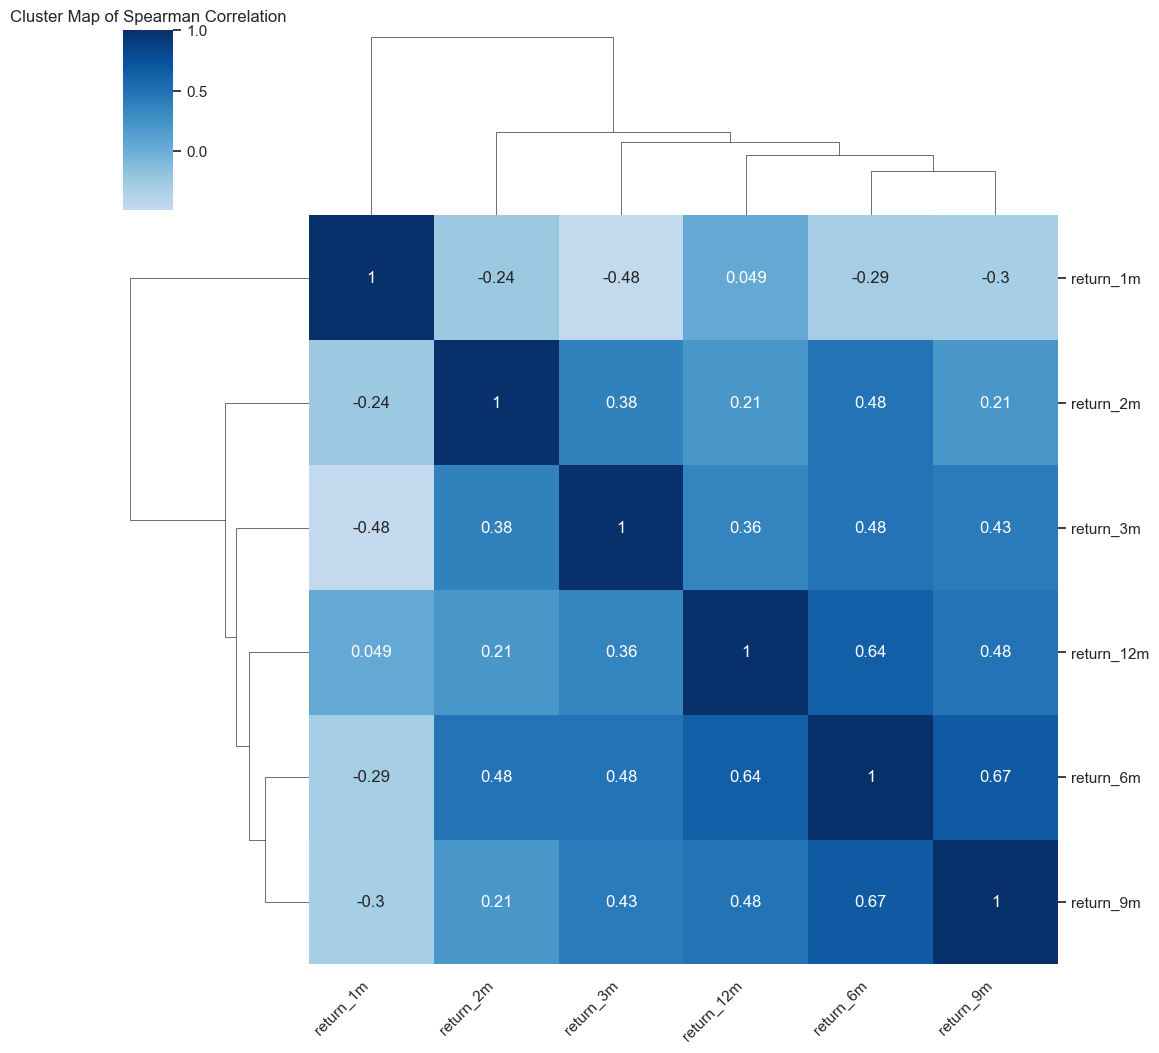

In [6]:
# Calculate the Spearman correlation matrix
correlation_matrix = data.corr('spearman')

# Create a cluster map
sns.set(rc={'figure.figsize':(10, 8)})
clustermap = sns.clustermap(correlation_matrix, annot=True, center=0, cmap='Blues')

# Adjust plot aesthetics
plt.setp(clustermap.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
plt.setp(clustermap.ax_heatmap.get_yticklabels(), rotation=0)
plt.title("Cluster Map of Spearman Correlation")

# Show the plot
plt.show()

## LATER Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [21]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2000-01-31 to 2021-02-28
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  254 non-null    float64
 1   SMB     254 non-null    float64
 2   HML     254 non-null    float64
 3   RMW     254 non-null    float64
 4   CMA     254 non-null    float64
dtypes: float64(5)
memory usage: 11.9 KB


In [22]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [23]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [24]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,360752.000000
mean,0.981855,0.628163,0.128131,-0.059253,0.013774,1.494318
std,0.918800,1.248071,1.615972,1.919938,2.182730,3.291402
min,-9.922641,-10.212033,-17.654894,-22.925165,-18.182706,-31.429456
25%,0.465445,-0.114605,-0.710399,-0.979216,-1.086919,0.000000
50%,0.932070,0.542998,0.101903,0.039229,0.032834,1.214277
75%,1.447381,1.303487,0.955263,0.955362,1.140431,3.145515
max,10.916430,10.373043,14.558920,17.413382,17.626042,33.316296


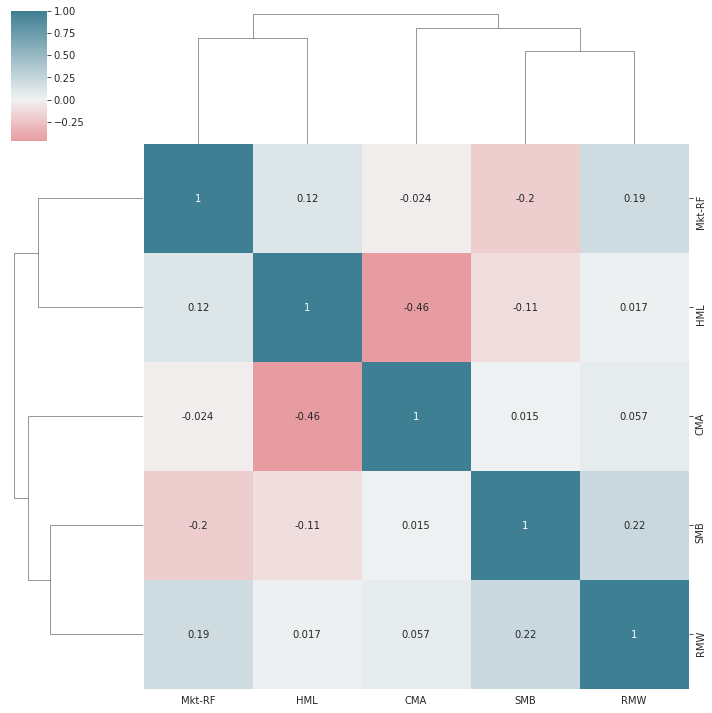

In [25]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [26]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


### Impute mean for missing factor betas

In [27]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


## LATER  Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [28]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [29]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [30]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [31]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [32]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.329564      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.329564  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [34]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [35]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 139.9+ KB


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [36]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 1838 entries, A to ZUMZ
dtypes: float64(1838)
memory usage: 2.9 MB


In [37]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [38]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [39]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [41]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/engineered_features                        frame        (shape->[358914,33])                                                                
/quandl/wiki/prices                         frame        (shape->[15389314,12])                                                              
/quandl/wiki/stocks                         frame        (shape->[1,2])                                                                      
/sp500/fred                                 frame        (shape->[2609,1])                                                                   
/sp500/sp500_stooq                          frame        (shape->[17700,5])                                                                  
/sp500/stocks                               frame        (shape->[1,7])                                                                      
/sp500/stooq                                frame        (shape->[17700,5])      

## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [42]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64
